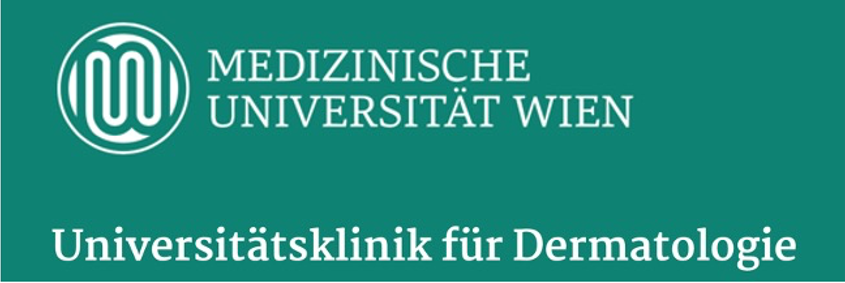

# <p style="text-align: center;"> Introduction to single cell analysis <br> (OEGDV 2025) </p>

### In this notebook we will analyse a subset of cell from the dataset associated to this [publication](https://www.science.org/doi/10.1126/science.aba6500?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed)  

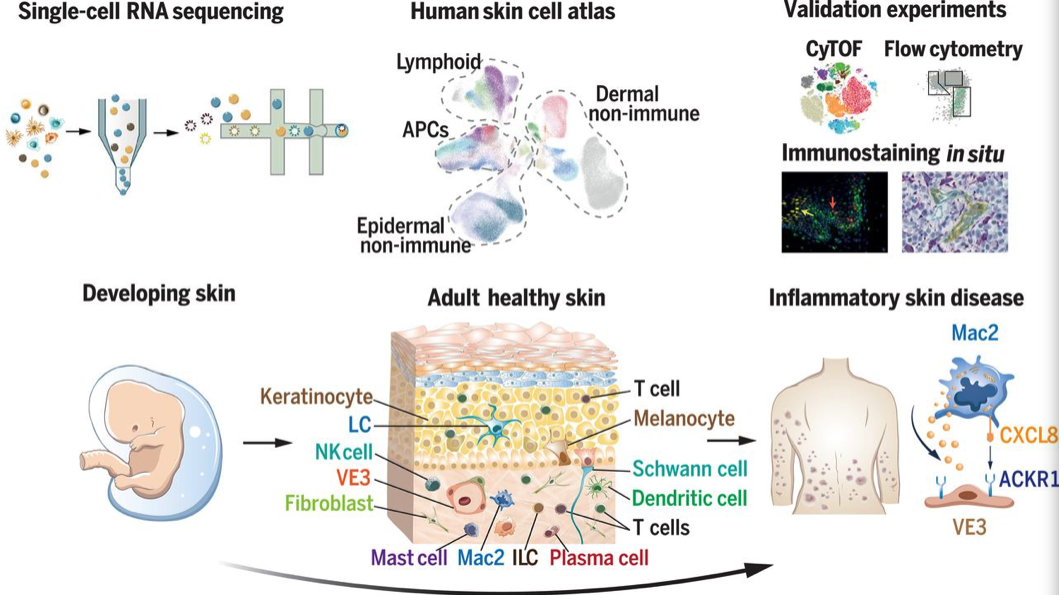

  
The dataset contains around 500k cells; I extracted 4 random samples from this dataset for this notebook  

#### Jupyter notebooks are also available via GitHub: [here](https://github.com/Mwielscher/OEGDV_scRNAseq/tree/main)

In [ ]:
library(Seurat)

In [ ]:
load("PMID_33479125_sample1.RData")
sc.dat=CreateSeuratObject(mtx,assay = "RNA",min.cells = 15, min.features = 400) 
class(sc.dat)

## Seurat S4 objects in R:  
>* very similar to lists  
>* they follow conventions so every R user can use them. 
>* there are some generic functions that can be applied on any S4 object. 
>* they are used to keep results and data tidy  

In [ ]:
getClass(sc.dat)     ## get an overview of any S4 object
class(sc.dat)
isS4(sc.dat)

In [ ]:
str(sc.dat)

>## Navigate S4 objects:

In [ ]:
summary(sc.dat@assays)         ## this can be found in assays

In [ ]:
sc.dat@assays  

In [ ]:
summary(sc.dat@reductions)             ## empty for now -- if we run a PCA analysis on the object it would fill up

In [ ]:
head(sc.dat@meta.data)  ## different because this not a slot like assay, we are already at the dataframe

In [ ]:
pheno.dat=as.data.frame(sc.dat@meta.data)
dim(pheno.dat)
class(pheno.dat)

### Basic QC should be done for each sample separately before merging into larger-scale projects:  

### 1. check mitochondrial RNA content

In [ ]:
## Mitochondiral Genes measured
genes=as.character(rownames(sc.dat))
genes[grepl("^MT-", genes)]

In [ ]:
## create a percent.mt variable in meta data
sc.dat[["percent.mt"]] <- PercentageFeatureSet(sc.dat, pattern = "^MT-")
head(sc.dat@meta.data)

In [ ]:
sample_ID=c("PMID_33479125_sample1")
perc_mt=sc.dat@meta.data$percent.mt
a=c(seq(0,5,by=0.2)[1:length(seq(0,max(perc_mt),by=0.2))-1],max(perc_mt))
hist(perc_mt,breaks=a,freq=F,main=paste("Expression of mitochondrial genes\n sample:",sample_ID,sep=" "), ylab=c("number of cells"),xlab=c("MT expression in %"))
abline(v=median(perc_mt),col="red",lwd=2)
abline(v=quantile(perc_mt,probs = seq(0,1,by=0.25))[2],col="green",lty=2,lwd=2)  # 25%
abline(v=quantile(perc_mt,probs = seq(0,1,by=0.25))[4],col="green",lty=2,lwd=2)  # 75%
abline(v=(median(perc_mt)+3*(mad(perc_mt))),col="blue",lty=2,lwd=2)
legend("right", legend=c("median", "25% and 75% percentile","outlier threshold (3xMAD)"),
       col=c("red", "green","blue"), lty=c(1,2,2),lwd=1.5, cex=0.8)            
table(perc_mt > 5)

#### exlclude samples with high mitchondiral RNA content

In [ ]:
## set NA to 0 is necessary for the filter step to work NA < 5 produces NA instead of TRUE or FALSE
sc.dat@meta.data$percent.mt[is.na(sc.dat@meta.data$percent.mt)]=0
dim(sc.dat)
sc.dat1=sc.dat[, sc.dat@meta.data$percent.mt < 5]
dim(sc.dat1)

### UMI per cell (library size)

>* when planning our 10xGenomics scRNAseq experiment, we usullay aim for 80mio to 120mio raw reads per sample

In [ ]:
umi_per_cell=apply(sc.dat1@assays$RNA@counts,2,sum)
ave_per_cell=apply(sc.dat1@assays$RNA@counts,2,mean)
## easy way:
#umi_per_cell=sc.dat1@meta.data$nCount_RNA

lib_size_mad=mad(umi_per_cell)
a=c(seq(0,max(umi_per_cell/1000),by=3)[1:length(seq(0,max(umi_per_cell/1000),by=3))-1],max(umi_per_cell/1000))
options(warn=-1)
hist(umi_per_cell/1000,freq=T,
     main=paste("UMI per cell (library size)\n sample:",sample_ID,sep=" "), ylab=c("number of cells"),xlab=c("UMI per cell in thousands"))
abline(v=median(umi_per_cell/1000),col="red",lwd=2)
abline(v=quantile(umi_per_cell/1000,probs = seq(0,1,by=0.25))[2],col="green",lty=2,lwd=2)  # 25%
abline(v=quantile(umi_per_cell/1000,probs = seq(0,1,by=0.25))[4],col="green",lty=2,lwd=2)  # 75%
#abline(v=(median(umi_per_cell)+5*(mad(umi_per_cell)))/1000,col="blue",lty=2,lwd=2)
legend("right", legend=c(paste0("median = ",median(umi_per_cell/1000)), "25% and 75% percentile"),
       col=c("red", "green"), lty=1:2,lwd=1.5, cex=0.8, title="width of each bin = 3",title.adj=0)



### Genes per cell

In [ ]:
feature_per_cell=sc.dat1@meta.data$nFeature_RNA
a=c(seq(0,max(feature_per_cell),by=200)[1:length(seq(0,max(feature_per_cell),by=200))-1],max(feature_per_cell))
hist(feature_per_cell,breaks=a,freq=T,
     main=paste("Feature per cell\n sample:",sample_ID,sep=" "), ylab=c("number of cells"),xlab=c("features per cell"))
abline(v=median(feature_per_cell),col="red",lwd=2)
abline(v=quantile(feature_per_cell,probs = seq(0,1,by=0.25))[2],col="green",lty=2,lwd=2)  # 25%
abline(v=quantile(feature_per_cell,probs = seq(0,1,by=0.25))[4],col="green",lty=2,lwd=2)  # 75%
legend("right", legend=c("median", "25% and 75% percentile"),
       col=c("red", "green"), lty=1:2,lwd=1.5, cex=0.8, title="width of each bin = 200",title.adj=0)

## saturation plot  
>should get flat at the right end  
>if it looks linear --  coverage is too low

In [ ]:
library(ggplot2)
sat=as.data.frame(cbind(sc.dat1@meta.data$nFeature_RNA,umi_per_cell))
colnames(sat)=c("feature_per_cell","umi_per_cell")
sat=sat[order(sat$feature_per_cell),]
colnames(sat)=c("GENES","nUMI")
p=ggplot(sat,aes(x=nUMI,y=GENES)) +
geom_point(alpha=0.1)+
stat_smooth(method=loess)
p

>## sequencing saturation:   
Sequencing saturation is a measure of the fraction of library complexity that was sequenced in a given experiment. The inverse of the sequencing saturation can be interpreted as the number of additional reads it would take to detect a new transcript. 
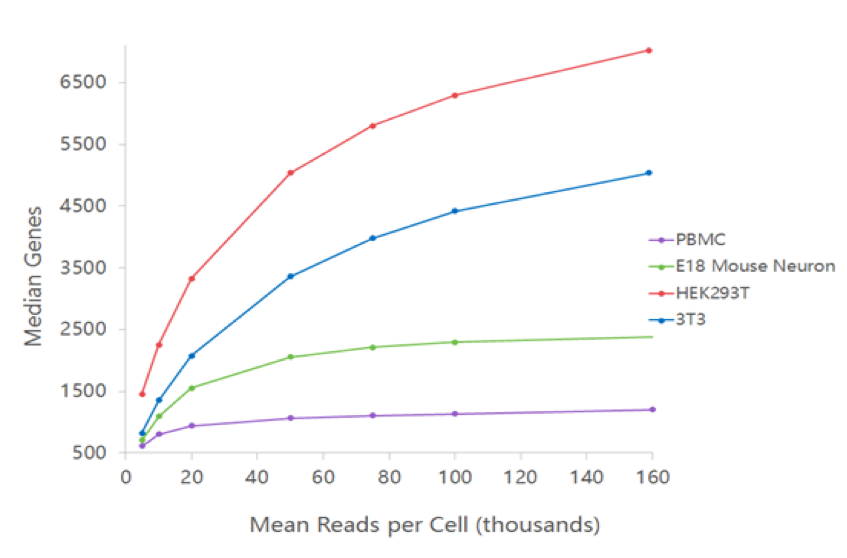  
[source: 10x Genomics](https://kb.10xgenomics.com/hc/en-us/articles/115005062366-What-is-sequencing-saturation-)  
>### basically this plot shows us if would have found more genes if we would have sequeneced deeper or if we already reached saturation  

In [ ]:
umi_per_feature=apply(sc.dat1@assays$RNA@counts,1,sum)
ave_per_feature=apply(sc.dat1@assays$RNA@counts,1,mean)
total=dim(sc.dat1)[2]
one=format(mean(umi_per_feature[log10(ave_per_feature)<log10(0.2)]),digits=1)
two=format(mean(umi_per_feature[log10(ave_per_feature)<log10(0.05)]),digits=1)
drei=format(mean(umi_per_feature[log10(ave_per_feature)<log10(0.01)]),digits=1)
four=format(mean(umi_per_feature[log10(ave_per_feature)<log10(0.005)]),digits=1)

hist(log10(ave_per_feature),breaks=50,main=c("Average expression per feature"),xlab=c("log10(mean expression per feature)"),
     ylab=c("number of features"))
abline(v=log10(0.2),col="blue",lty=2,lwd=2)
abline(v=log10(0.05),col="green",lty=2,lwd=2)
abline(v=log10(0.01),col="red",lty=2,lwd=2)
abline(v=log10(0.005),col="black",lty=2,lwd=2)

legend("topright", legend=c(paste("equals",four,"reads distibuted over",total,"cells"), 
                            paste("equals",drei,"reads distibuted over",total,"cells"),
                            paste("equals",two,"reads distibuted over",total,"cells"),
                            paste("equals",one,"reads distibuted over",total,"cells")),
       col=c("black", "red","green","blue"), lty=c(2),lwd=1.5, cex=0.8, title="expression in numbers",title.adj=0)



### as this sample is part of a cohort of 4 samples I will not remove any genes (features) at this point

### I usually restrict to cells with at least 1000 UMIs  
>* if this steps excludes too many cells in your dataset you might __rethink your coverage__ (re-sequence?)

In [ ]:
umi_per_cell=apply(sc.dat1@assays$RNA@counts,2,sum)
sc.dat2=sc.dat1[,umi_per_cell >999] 
dim(sc.dat1)
dim(sc.dat2)

## SEURAT SCT standard integration and clustering  

### about Seurat [SCTransform](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1) (coverage normalization and variance stabilization):  
>* __aim1: the normalized expression level of a gene should not be correlated with the total sequencing depth of a cell.__  
>* __aim2: The variance of a normalized gene should be independent of gene abundance or sequencing depth__   
  
### Seurat achives that by:  
1. **Fitting a negative binomial regression model for each gene**  
    - Example: `counts ~ sequencing depth + cell cycle + percMT + batch + etc.` (across all cells)  

2. **Regularizing between genes with similar abundance**  
    - This is necessary because the negative binomial (NB) model tends to overfit.  
    - Seurat models the global dependence between each parameter value and average gene expression, then applies a penalty (simplified) to each regression model to mitigate overfitting.  

3. **Computing the Pearson residuals of this regression**  
    - Pearson residuals are better suited for count data.  
    - Additionally, they are standardized to the predicted value, meaning the variance they capture is independent of the abundance of reads (UMIs).  




### What are residuals?  

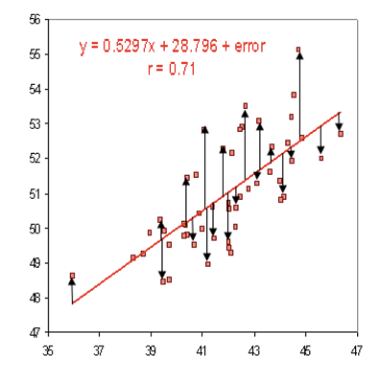

For simplicity, we use **linear regression** as an example (note: actual count data follows a different model):    

- **Y** represents the **library size** (UMIs per cell).  
- **X** represents the **counts** for a specific gene.  
- The **red line** is the **regression line**, which captures the overall trend in the data.  
- The **difference between each point and the regression line** is called the **residual**.  
- **Simplified:** The goal is to **remove systematic trends** introduced by variations in **library size per cell**.  
- While **linear regression** serves as an intuitive example, in **Seurat**, a **negative binomial regression model** is used instead, as it better accounts for the characteristics of count data. However, the core idea remains the same—capturing and removing systematic trends in the data.


### regress out expression influenced by cell cycle  
>* the idea is to [calculate cell cycle phase scores](https://satijalab.org/seurat/archive/v3.1/cell_cycle_vignette.html) based on canonical markers, and then regress these out of the data during pre-processing  
>* scores for each cell are stored in meta data. 
>* we will be regressing out the difference between the G2M and S phase scores  
>* this way signals separating non-cycling cells and cycling cells will be maintained, but differences in cell cycle phase amongst proliferating cells (which are often uninteresting), will be regressed out of the data  

In [ ]:
## this initial round is done just to calculate cell cycle scores
dat1=SCTransform(sc.dat2, variable.features.n = NULL,conserve.memory = F, return.only.var.genes = F)
s.genes = cc.genes$s.genes   ## these lists are loaded with Seurat
g2m.genes = cc.genes$g2m.genes
dat1 =CellCycleScoring(dat1, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
dat1$CC.Difference = dat1$S.Score - dat1$G2M.Score

In [ ]:
head(dat1@meta.data)

### How Principal Component Analysis (PCA) works  

> **Aim 1:** Reduce the dimensionality of the data  
> **Aim 2:** Identify structures and outliers in the data  

⚠️ **Data Requirement:** PCA requires the data to be **scaled and centered** for meaningful results. This means that each feature (gene) should have **mean = 0** and **variance = 1**  ⚠️ 

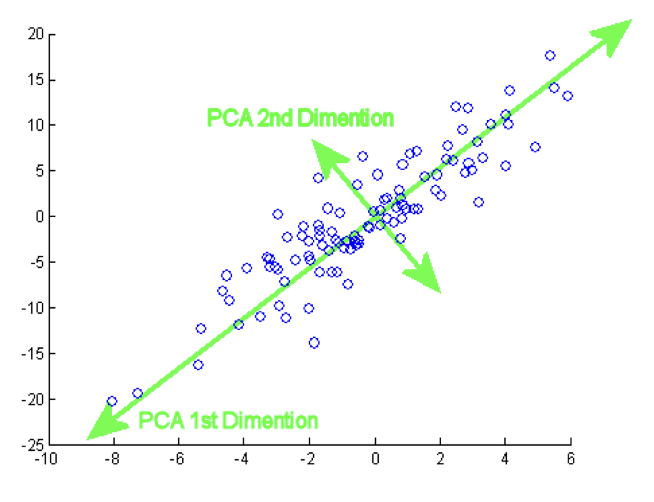

- **Y** represents the UMIs in **gene A**.    
- **X** represents the UMIs in **gene B**.  
- **Step 1:** Find the center of the data.  
- **Step 2:** Find the line that maximizes the total variance in the data → This is **PC1 (Principal Component 1)**, also called an **Eigenvector**.  
- **Step 3:** Project each data point onto PC1 to determine its position along this axis. This process is called **Singular Value Decomposition (SVD)**.  
- **Step 4:** **PC2 (Principal Component 2)** follows the same rule but must be **perpendicular** to PC1.  

---

### Beyond Two Dimensions  

- Instead of analyzing just **two genes (gene A and gene B)**, PCA can be **extended to thousands of genes** (e.g., **20,000 genes** in single-cell RNA-seq data).  

- The contribution of individual genes to each principal component is called **loading**. The **direction** of a PC (i.e., what variance it explains) is primarily determined by genes with the **highest loadings**.



In [ ]:
library(dplyr)
dat1=SCTransform(dat1, variable.features.n = NULL,vars.to.regress=c("nCount_RNA","percent.mt","CC.Difference"),
            conserve.memory = F, return.only.var.genes = F) %>% RunPCA(verbose = TRUE)

In [ ]:
Seurat::DimHeatmap(dat1, reduction = "pca",dims = 1, cells = 500, balanced = TRUE)  ### plot the top 500 cells (highest scores)
Seurat::DimHeatmap(dat1, dims = 2,reduction = "pca", cells = 500, balanced = TRUE)  ### plot the top 500 cells (highest scores)
Seurat::DimHeatmap(dat1, dims = 3,reduction = "pca", cells = 500, balanced = TRUE)
Seurat::DimHeatmap(dat1, dims = 4, reduction = "pca",cells = 500, balanced = TRUE)
Seurat::DimHeatmap(dat1, dims = 5,reduction = "pca", cells = 500, balanced = TRUE)
Seurat::DimHeatmap(dat1, dims = 6,reduction = "pca", cells = 500, balanced = TRUE)
Seurat::ElbowPlot(dat1,reduction="pca")

In [ ]:
## due to technical reasons we will run TSNE instead of UMAP
sig_PCs=c(1:12)
dat1 = RunTSNE(dat1, reduction.use = "pca",dims = sig_PCs)
dat1=Seurat::FindNeighbors(dat1,reduction = "pca",k.param = 20,dims=sig_PCs)

In [ ]:
clust_test=function(sce) {
  cont=as.data.frame(matrix(NA,nrow=length(unique(Idents(sce))), ncol=4))
  colnames(cont)=c("cluster","cells","mean_total_UMI","mean_features")
  i=1
  for (k in unique(Idents(sce))) {
    print(c(k))
    cont[i,1]=c(k)
    dat23=sce@assays$RNA@counts[,Idents(sce)%in%c(k)]
    cont[i,2]=table(Idents(sce)%in%c(k))[2]
    cont[i,3]=mean(apply(dat23,2,function(x)sum(x)))
    cont[i,4]=mean(apply(dat23,2,function(x)table(x %in% c(0))[1]))
    i=i+1
  }
  cont=cont[order(as.numeric(as.character(cont$cluster))),]
  return(cont)
}

In [ ]:
library(ggplot2)
clust.res=0.3     ## change and rerun
dat1=Seurat::FindClusters(dat1,resolution=clust.res)  
pl=Seurat::DimPlot(dat1, reduction = "tsne")
pl= pl+ ggtitle(paste("TSNE visualization of cell clusters \n at resolution",clust.res,sep=" ")) +
  theme (plot.title = element_text(color="black", size=14, face="bold",hjust = 0.5))
pl
res1=clust_test(dat1)
res1

In [ ]:
i=c("JCHAIN")  ## CD8A
p=FeaturePlot(dat1, features = as.character(i))
p